<a href="https://colab.research.google.com/github/PetchMa/ML_GravitationalWaves/blob/master/Data_access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gravitational Wave Detection 
### Peter Ma | Aug 21 2020
### GWOSC For Opensourcing Data
This notebook is an introduction on how traditional methods tackles the problem of detecting very faint transient signals/candidates within the GWOSC Dataset. This notebook is a derivative from the tutorials. Except I will try to expose more of the code thats ben abstracted away in the `GWpy` library.

Extra dataset: https://zenodo.org/record/1476551#.X0CHoOhKiUk 



# Library 
I will use the library built by the folks at `GWpy` as an `I/O` for the data. I'm interested in the `Numpy` arrays in which to do the actual analysis. We first install the library and set the GPS time. 

In [33]:
! pip install -q gwpy

# Time Indication

Now we want query data with a specific time that was recorded. And in this case there was one recording `2005 Sept 9th` that we know recorded a gravitational wave. We want to then see if we can detect that!

In [34]:
import time 
# -- Set a GPS time:
t0 = 1126259462.4    # -- GW150914
print("Time Data Recorded: "+time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t0)))
print("Current Time: "+ time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

#-- Choose detector as H1, L1, or V1
detector = 'H1'

Time Data Recorded: 2005-09-09 09:51:02
Current Time: 2020-08-21 23:57:20


In [35]:
import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from gwpy.timeseries import TimeSeries

# Querying Data

There is a list of saved API links that give us access to the data. We just need to query the specific time to access those datasets! We can use the `get_urls()` function to get this data. 

We read in a `H5` file which includes metadata that we're going to read in from the `TimeSeries` module.


In [36]:
from gwosc.locate import get_urls
# We are getting the Hadford1 detector. 
url = get_urls(detector, t0, t0)[-1]

print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:                 
    straindata = requests.get(url)
    strainfile.write(straindata.content)

Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


# Ploting and Visualizing Data
We want to checkout what our data actually contains. So we plot the time series data and we center it around the detection. Notice how we can't really tell where the gravitational wave is just based on observation. So how might we get more info from this??

Lets play around with the raw `Numpy` data array that we get. You can directly access the data by referencing the `values` attribute. 


Start: 2005-09-09 09:50:46
End: 2005-09-09 09:51:18


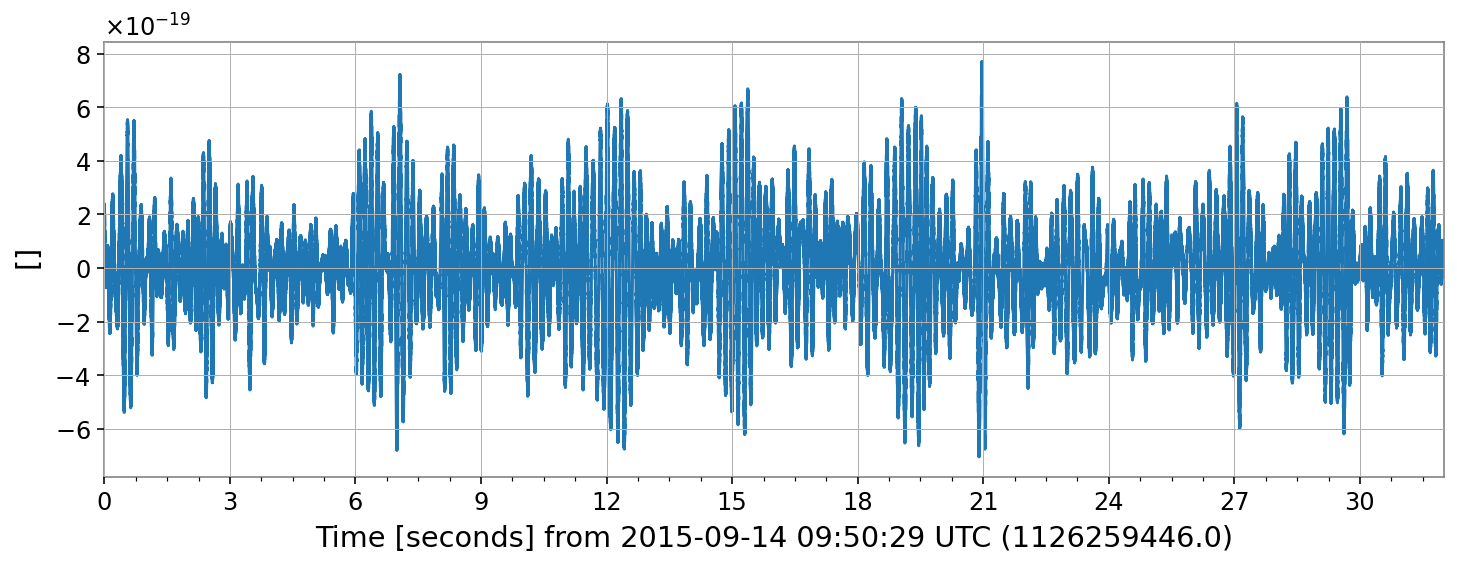

In [37]:
# -- Read strain data
strain = TimeSeries.read(fn,format='hdf5.losc')
center = int(t0)
print("Start: "+time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(center-16)))
print("End: "+time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(center+16)))
strain = strain.crop(center-16, center+16)
# Get the data
data = strain.value 
strain.plot()
fig1 = strain.plot()

(500,)


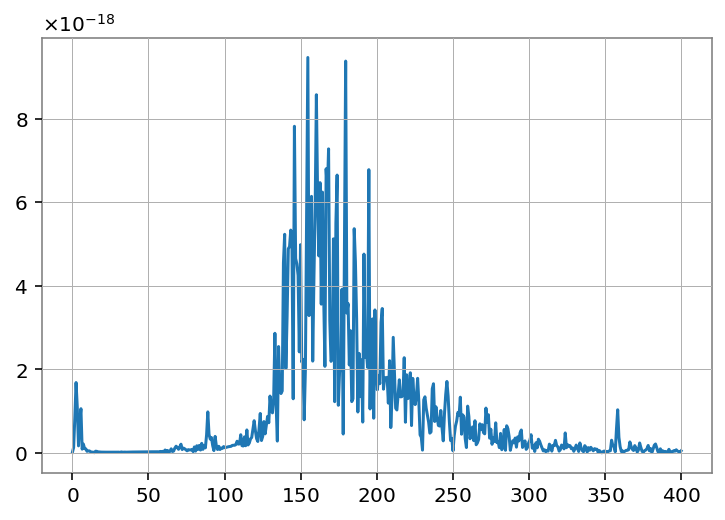

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 1000
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(data)
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

print(xf.shape)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

(1e-24, 1e-19)

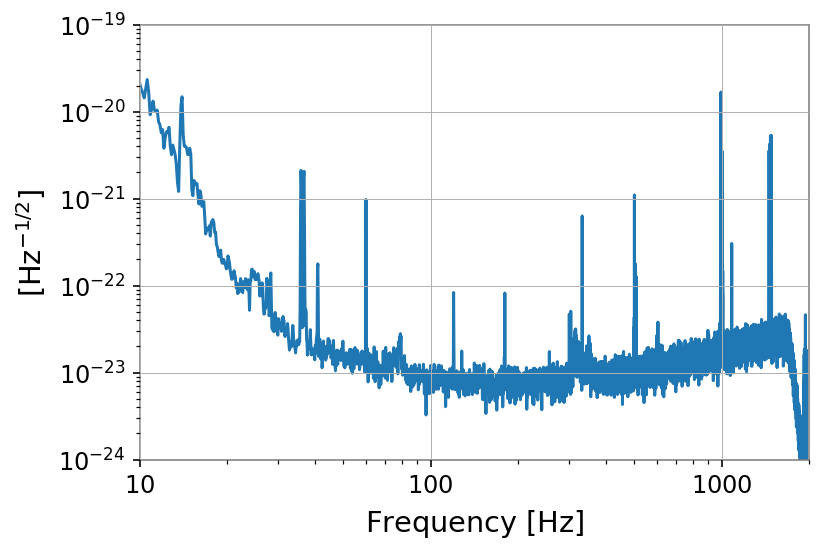

In [6]:
# -- Plot ASD
fig2 = strain.asd(fftlength=8).plot()
plt.xlim(10,2000)
plt.ylim(1e-24, 1e-19)

(1126259462.2, 1126259462.5)

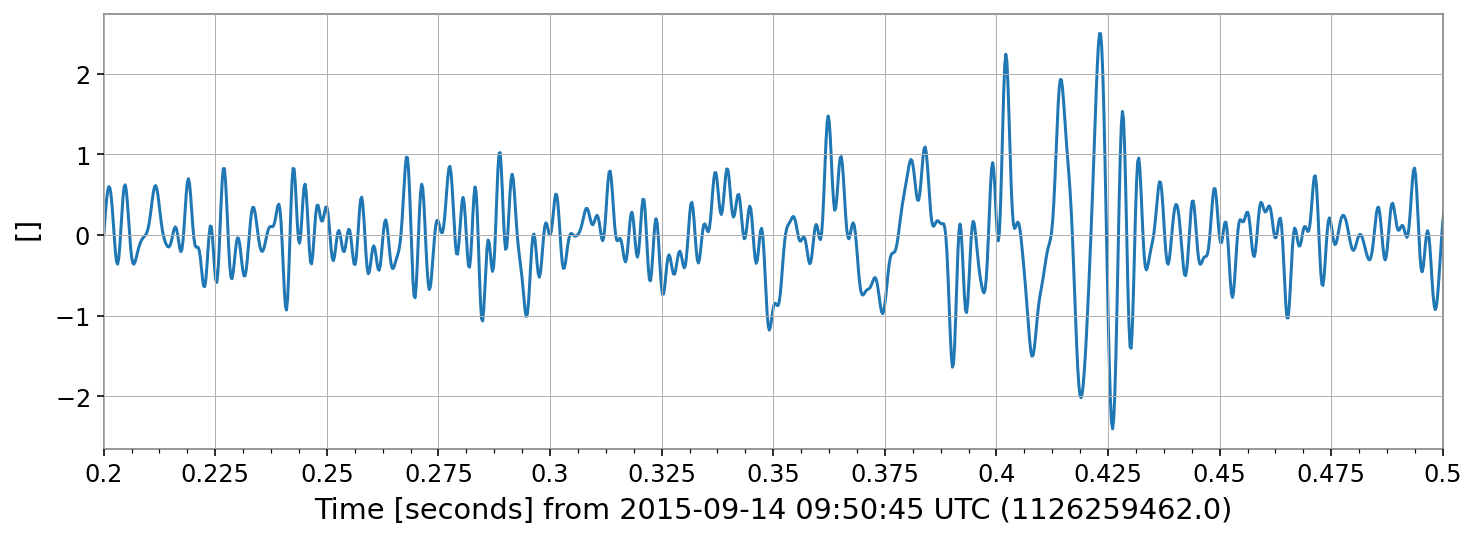

In [7]:
# -- Whiten and bandpass data
white_data = strain.whiten()
bp_data = white_data.bandpass(30, 400)
fig3 = bp_data.plot()
plt.xlim(t0-0.2, t0+0.1)

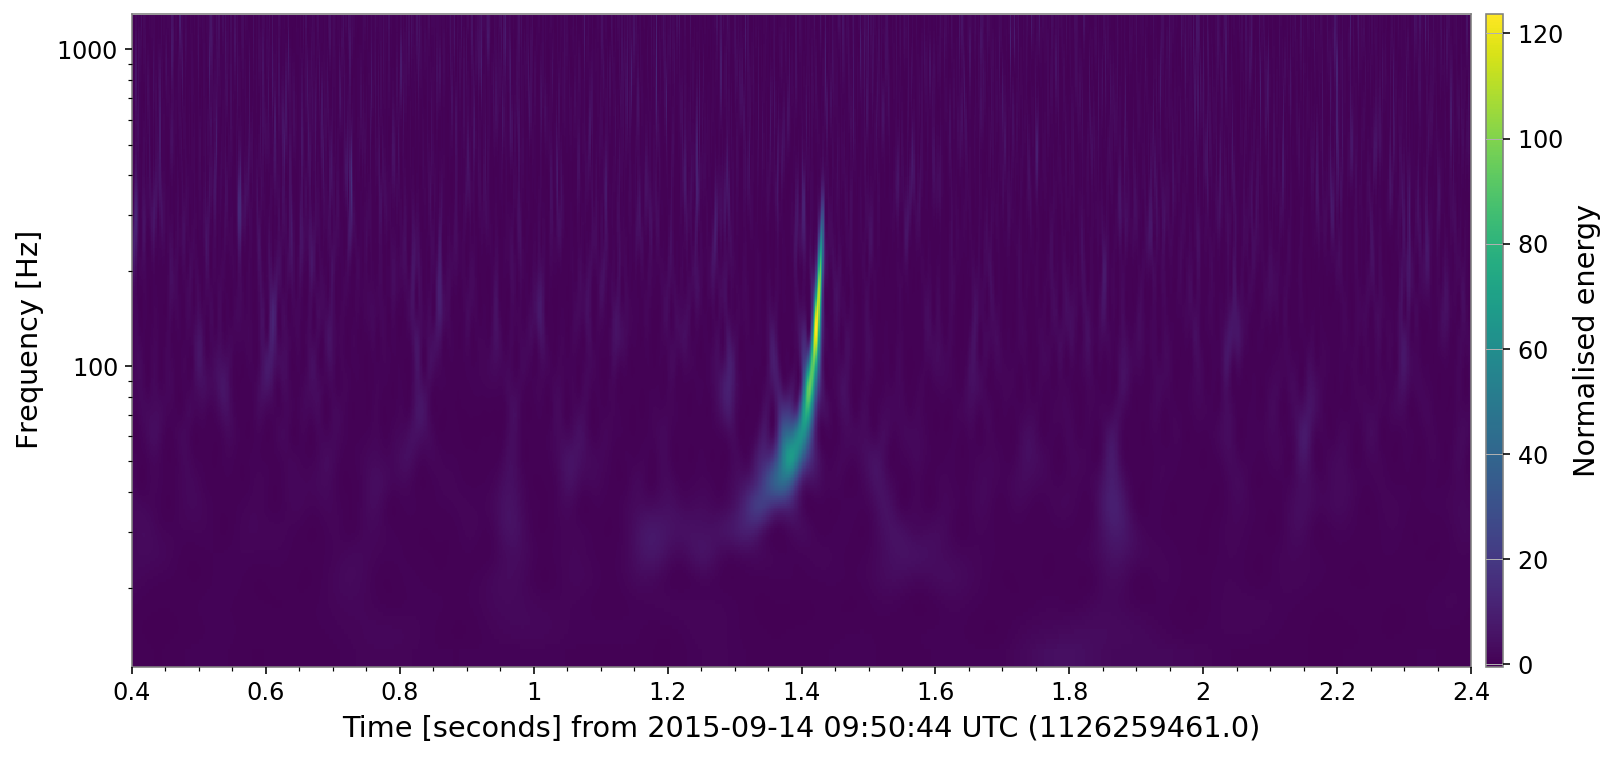

In [8]:
dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(t0-dt, t0+dt))
fig4 = hq.plot()
ax = fig4.gca()
fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')